In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
training_file = 'data/churn_train.csv'
test_file = 'data/churn_test.csv'

In [10]:
df0 = pd.read_csv(training_file)

Prepare X and y

In [32]:
def prep_X_y(df):
    # Remove some samples
    df = df0[df0['city'] != "King's Landing"].copy()
    df.drop(['avg_rating_of_driver'],axis=1,inplace=True)

    # Create y
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    y = (df['last_trip_date'] < '2014-06-01')
    df.drop(['last_trip_date'],axis=1,inplace=True)

    # convert dates to numeric
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    td = df['signup_date'].max() -  df['signup_date']
    df['days_since_signup']=(td.dt.days)
    df.drop(['signup_date'],axis=1,inplace=True)

    # Fill missing data with average
    mean_rating = df['avg_rating_by_driver'].mean()
    df['avg_rating_by_driver'].fillna(mean_rating, inplace=True)

    # Fill and expand categorical data
    df['phone'].fillna("No phone", inplace=True)
    df = pd.concat([df,pd.get_dummies(df['phone'])],axis=1)
    df.drop(['phone'],axis=1,inplace=True)

    # Expand other categorical data
    df = pd.concat([df,pd.get_dummies(df['city'])],axis=1)
    df.drop(['city'],axis=1,inplace=True)

    X = df
    return X, y

In [33]:
X, y = prep_X_y(df0)

Create train & CV

In [28]:
X.head()

,avg_dist,avg_rating_by_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_signup,Android,No phone,iPhone,Astapor,Winterfell
0,6.94,5.0,1.00,0.0,0,False,100.0,19,1,0,0,1,0
1,8.06,5.0,1.00,0.0,2,True,0.0,6,1,0,0,1,0
2,21.50,4.0,1.00,0.0,1,True,100.0,29,0,0,1,0,1
3,9.46,5.0,2.75,100.0,1,False,100.0,22,1,0,0,0,1
4,13.77,5.0,1.00,0.0,0,False,100.0,0,0,0,1,0,1


In [29]:
X_train, X_cv, y_train, y_cv = train_test_split( X, y, test_size=0.2, random_state=42)

# Gradient boost classifier

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
N_ESTIMATORS = 1000
# loss: deviance: logistic log likelihood
model = GradientBoostingClassifier(learning_rate=0.01, 
                                   n_estimators=N_ESTIMATORS, 
                                   min_samples_leaf=10)

model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [42]:
def plot_feature_importance(model, X_train):
    # Plot the feature importance
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('ggplot')
    fig,ax = plt.subplots(figsize=(16,16))
    feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                              index=X_train.columns)
    feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
    feat_scores.plot(kind='barh',ax=ax)

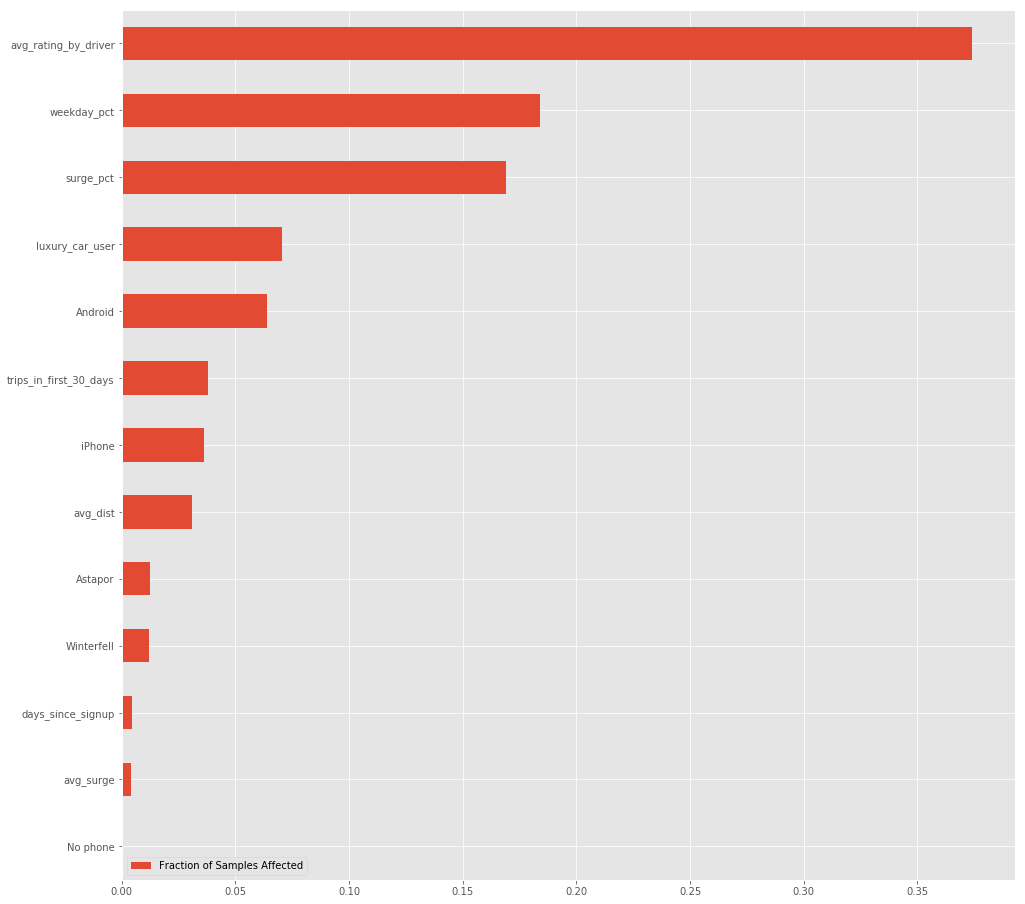

In [43]:
plot_feature_importance(model, X_train)

## Test data

In [36]:
df_test = pd.read_csv(test_file)

Remove unwanted columns

In [37]:
X_test, y_test = prep_X_y(df_test)

In [38]:
print('Train score:',model.score(X_train, y_train))
print('CV score:',model.score(X_cv, y_cv))
print('Test score:',model.score(X_test, y_test))

Train score: 0.7972453304033904
CV score: 0.8074387947269304
Test score: 0.7992842792566549
